[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/lzanda/demo_amazon_sagemaker_studio_lab/blob/main/CNN-Mario/CCN-Mario.ipynb)
# Clasificación de imagenes con CNN - Super Mario Bros

## Antecedentes

La clasificación de imágenes (o reconocimiento de imágenes) es un subdominio de la visión por computadora en el que un algoritmo mira una imagen y le asigna una etiqueta de una colección de etiquetas o categorías predefinidas en las que se ha entrenado.

La visión es responsable del 80-85 por ciento de nuestra percepción del mundo, y nosotros, como seres humanos, realizamos diariamente clasificaciones triviales de cualquier información con la que nos encontremos.

Por lo tanto, emular una tarea de clasificación con la ayuda de redes neuronales es uno de los primeros usos de la visión artificial en los que pensaron los investigadores.


## Clasificación de niveles Super Mario Bros (Data set)
En este ejercicio se explorará la utilidad y funcionamiento de las redes convolucionales para clasificar diferentes niveles del juego de atari Super Mario bros a partir de imágenes del mismo.<br>


El dataset disponible contiene imágenes de los niveles: 1,5,6,7 de Super Mario bros a clasificar. Este se encuentra en la carpeta Dataset del mismo repositorio en Github ( https://github.com/lzanda/demo_amazon_sagemaker_studio_lab ) Cada dato contiene una imagen estática de alguna parte de cualquiera de las etapas del nivel o clase en cuestión. Vale la pena aclarar que cada uno de los niveles contiene cuatro etapas diferentes en donde varía el entorno, los obstaculos y los enemigos a los cuales se debe enfrentar Mario. 

![Imagen Mario](Dataset/imagenMario.png)

## Etapas en este Notebook

Los pasos principales son:
- instalar paquetes
- cargar conjunto de datos, qué estan divididos en entrenamiento, testeo y validación
- Visualización de 2 imagen del conjunto de datos 
- Importación de imagenes con ayuda de OpenCV
- Inspección de Dataset
- Preprocesamiento de Datos
- iniciar el modelo NN
- entrenar un modelo con config
- probar un modelo
- imprimir una figura con la predición que se obtiene apartir del modelo entrenado

## Instalación de paquetes necesarios:

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym-super-mario-bros > /dev/null 2>&1
%conda install opencv
%conda install -c anaconda keras
%conda update wrapt
%pip install tensorflow
%pip install tensorflow-gpu
%pip install tensorflow

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/cv

  added / updated specs:
    - opencv


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge::ca-certificates-2021.10.8-ha878542_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/cv

  added / updated specs:
    - keras


The following packages will be SUPERSEDED by a higher

In [3]:
# Importación de paquetes necesarios 
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from IPython.display import clear_output
import time
# Importación de paquetes necesarios para la creación de la red convolucional
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

## Visualización de Imagenes del Dataset
_A tener en cuenta:_ La sintaxis del ambiente de Mario Bros es:

'SuperMarioBros-Nivel-Etapa-v0'

En donde cada nivel cuenta con 4 etapas por separado y el ambiente un total de 8 niveles. Para este problema en especifico, solo manejaremos los niveles 1,5,6 y 8. 


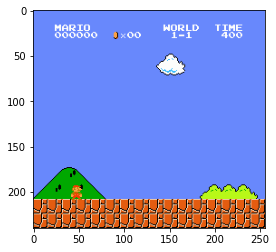

In [4]:
# Imagen del nivel 1 - Etapa 1
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
screen = env.render(mode='rgb_array')
plt.imshow(screen)
env.close()

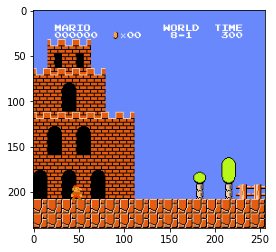

In [5]:
# Imagen del nivel 8 - Etapa 1
env = gym_super_mario_bros.make('SuperMarioBros-8-1-v0') 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
screen = env.render(mode='rgb_array') # borrar
plt.imshow(screen) # borrar
env.close()

## Importar dataset con OpenCV
En primer lugar es importante importar la base de datos adjunta al notebook presente para poder resolver el problema de clasificación.  De forma adicional y paralelamente se creará un vector de etiquetas (**_Y_**) que contenga la clase a la que pertenece cada imagen:

- Clase 0 -> Nivel 1
- Clase 1 -> Nivel 5
- Clase 2 -> Nivel 6
- Clase 3 -> Nivel 8

In [6]:
# Importación de los paquetes necesario para: Import Dataset
import cv2
import random
import os
import numpy as np

In [7]:
# Creacion de los vectores vacíos para almacenar los datos
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = [] 
# Creación de variables para la importación de las imágenes
CATEGORIES = ['Nivel_1','Nivel_5','Nivel_6','Nivel_8']
FOLDERS = ['train','test','val']
# Importación de los datos
for folder in FOLDERS:
  data = [] # Variable temporal
  for category in CATEGORIES:
        path = os.path.join('./Dataset/'+category, folder)
        class_num_0 = CATEGORIES.index(category)
        for img in os.listdir(path):
          try:
            img_array = cv2.imread(os.path.join(path,img))
            data.append([img_array,class_num_0])
          except Exception as e:
            print("Not working")
            pass
        print(category+' of '+folder+' imported data done')
  random.shuffle(data)
  # Asignación de los datos de entrenamiento, validación o test:
  for features, label in data:
    if folder == 'train':
      X_train.append(features)
      Y_train.append(label)
    elif folder == 'test':
      X_test.append(features)
      Y_test.append(label)
    elif folder == 'val':
      X_val.append(features)
      Y_val.append(label)
  print(folder+' imported data done')        
print("Información importada")

Nivel_1 of train imported data done
Nivel_5 of train imported data done
Nivel_6 of train imported data done
Nivel_8 of train imported data done
train imported data done
Nivel_1 of test imported data done
Nivel_5 of test imported data done
Nivel_6 of test imported data done
Nivel_8 of test imported data done
test imported data done
Nivel_1 of val imported data done
Nivel_5 of val imported data done
Nivel_6 of val imported data done
Nivel_8 of val imported data done
val imported data done
Información importada


## Inspección de los datos

Ahora bien, una vez se cuente con la información importada se puede realizar una inspección de la naturaleza de los datos y de esta forma entender la necesidad de utilizar una red neuronal convolucional para su clasificación. Primer, se evidencia el tamaño de cada una de las imágenes que serán la entrada del modelo:

In [8]:
# La capa de entrada del modelo tendrá como entrada la dimensión de cada una de las imágenes de nuestro dataset
X_train[0].shape # 224 x 224 x 3 (El 3 significa cada uno de los canales de la imagen RGB)

(224, 224, 3)

Clase:  3


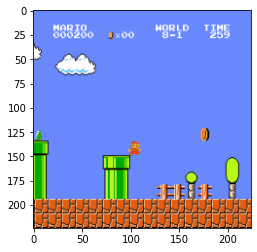

In [9]:
aleatorio = random.randint(0,len(X_train))
print('Clase: ' , Y_train[aleatorio])
plt.imshow( cv2.cvtColor(X_train[aleatorio] , cv2.COLOR_BGR2RGB)   ) # Digita cualquier número menor a la longitud de la base de datos de entrenamiento para inspeccionar alguna imagen

## Preprocesamiento de los Datos
S


In [11]:
from numpy import array
from numpy import argmax
# define example
data = Y_train
data = array(data)
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)
# invert encoding
inverted = argmax(encoded[0])
print(inverted)

[0 3 0 ... 2 1 2]
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
0
